In [1]:
import cv2
import numpy as np
from math import log10, sqrt
import matplotlib.pyplot as plt
import os

## Funcitons

In [2]:
def add_padding(img, block_size=8):
    h, w = img.shape[:2]
    if h % block_size != 0:
        h = h + block_size - h % block_size
    if w % block_size != 0:
        w = w + block_size - w % block_size
    img = cv2.copyMakeBorder(img, 0, h - img.shape[0], 0, w - img.shape[1], cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return img

In [3]:
def block_split(img, block_size=8):
    blocks = []
    blocks_1 = []
    blocks_2 = []
    blocks_3 = []
    for i in range(0, img.shape[0], block_size):
        for j in range(0, img.shape[1], block_size):
            blocks_1.append(img[i:i+block_size, j:j+block_size, 0]-128)
            blocks_2.append(img[i:i+block_size, j:j+block_size, 1]-128)
            blocks_3.append(img[i:i+block_size, j:j+block_size, 2]-128)
    blocks.append(blocks_1)
    blocks.append(blocks_2)
    blocks.append(blocks_3)
    return blocks

In [4]:
def dct_block(blocks):
    dct_blocks = []
    for i in range(len(blocks)):
        temp = []
        for block in blocks[i]:
            temp.append(np.round(cv2.dct(np.float32(block))))
        dct_blocks.append(temp)
    return dct_blocks

In [5]:
def quantization_block(blocks,Q):
    quantization_blocks = []
    for i in range(len(blocks)):
        temp = []
        for block in blocks[i]:
            temp.append(np.round(block/Q))
        quantization_blocks.append(temp)
    return quantization_blocks

In [6]:
def zigzag_block(blocks):
    zigzag_blocks = []
    for i in range(len(blocks)):
        temp = []
        for block in blocks[i]:
            n = len(block)
            output = []
            direction = 1
            pr,pc = -1,-1
            row, col = 0, 0
            while row < n and col < n:
                output.append(block[row][col])
                tr = row
                tc = col
                if col == n-1 and pc != n-1 and pr != 0:
                    row += 1
                    direction = 1
                elif row == n-1 and pr != n-1 and pc != 0:
                    col += 1
                    direction = -1
                elif row == 0 and pr != 0:
                    col += 1
                    direction = 1
                elif col == 0 and pc != 0:
                    row += 1
                    direction = -1
                else:
                    row += direction
                    col -= direction
                if len(output) == n*n:
                    break
                pr = tr
                pc = tc
            temp.append(output)
        zigzag_blocks.append(temp)
    return zigzag_blocks

In [7]:
def zero_trail_removal(blocks,coeff ,block_size=8,todo=False):
    zero_trail_removal_blocks = []
    for i in range(len(blocks)):
        temp = []
        for block in blocks[i]:
            if todo:
                temp.append(block[:coeff])
            else:    
                z = np.trim_zeros(block)
                if len(z) != block_size*block_size:
                    z.append(0)
                temp.append(z)
        zero_trail_removal_blocks.append(temp)
    return zero_trail_removal_blocks

In [8]:
def zero_trail_add(blocks,block_size=8):
    zero_trail_add_blocks = []
    for i in range(len(blocks)):
        temp = []
        for block in blocks[i]:
            temp.append(np.append(block, np.zeros(block_size*block_size-len(block))))
        zero_trail_add_blocks.append(temp)
    return zero_trail_add_blocks

In [9]:
def zigzag_rev_block(blocks,block_size=8):
    zigzag_rev_blocks = []
    for i in range(len(blocks)):
        temp = []
        for block in blocks[i]:
            n = block_size
            output = [[0 for _ in range(n)] for _ in range(n)]
            direction = 1
            pr,pc = -1,-1
            row, col = 0, 0
            for k in range(n*n):
                output[row][col] = block[k]
                tr = row
                tc = col
                if col == n-1 and pc != n-1 and pr != 0:
                    row += 1
                    direction = 1
                elif row == n-1 and pr != n-1 and pc != 0:
                    col += 1
                    direction = -1
                elif row == 0 and pr != 0:
                    col += 1
                    direction = 1
                elif col == 0 and pc != 0:
                    row += 1
                    direction = -1
                else:
                    row += direction
                    col -= direction
                pr = tr
                pc = tc
            temp.append(output)
        zigzag_rev_blocks.append(temp)
    return zigzag_rev_blocks


In [10]:
def quantization_rev_block(blocks,Q):
    quantization_rev_blocks = []
    for i in range(len(blocks)):
        temp = []
        for block in blocks[i]:
            temp.append(np.round(block*Q))
        quantization_rev_blocks.append(temp)
    return quantization_rev_blocks

In [11]:
def idct_block(blocks):
    idct_blocks = []
    for i in range(len(blocks)):
        temp = []
        for block in blocks[i]:
            temp.append(np.round(cv2.idct(np.float32(block))))
        idct_blocks.append(temp)
    return idct_blocks

In [12]:
def block_join(blocks,block_size,shape):
    img = np.zeros(shape)
    for i in range(len(blocks)):
        img_temp = np.zeros((shape[0],shape[1]))
        row = 0
        col = 0
        for j in range(len(blocks[i])):
            img_temp[row:row+block_size,col:col+block_size] = blocks[i][j]+128
            col += block_size
            if col >= shape[1]:
                row += block_size
                col = 0
        img[:,:,i] = img_temp

    return img

In [13]:
def RMSE(img,img1):
    return np.sqrt(((img-img1)**2).mean())

In [14]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):                    
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

## Image Encoding

In [15]:
def JPEG_encoder(filename, block_size, coeff=-1):
    img = cv2.imread(filename)
    img_yCbCr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img_yCbCr = add_padding(img_yCbCr,block_size=block_size)
    img_yCbCr_blocks = block_split(img_yCbCr,block_size=block_size)
    img_yCbCr_dct_blocks = dct_block(img_yCbCr_blocks)
    Q = [[16, 11, 10, 16, 24, 40, 51, 61], 
    [12, 12, 14, 19, 26, 28, 60, 55 ],
    [14, 13, 16, 24, 40, 57, 69, 56 ],
    [14, 17, 22, 29, 51, 87, 80, 62 ],
    [18, 22, 37, 56, 68, 109, 103, 77 ],
    [24, 35, 55, 64, 81, 104, 113, 92 ],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]]
    Q = np.array(Q)
    Q = cv2.resize(Q,(block_size,block_size),interpolation=cv2.INTER_NEAREST)
    img_yCbCr_quantization_blocks = quantization_block(img_yCbCr_dct_blocks, Q)
    img_yCbCr_zigzag_blocks = zigzag_block(img_yCbCr_quantization_blocks)
    if coeff==-1:
        todo = False
    else:
        todo = True
    img_yCbCr_zero_trail_removal_blocks = zero_trail_removal(img_yCbCr_zigzag_blocks,coeff=coeff,block_size=block_size,todo=todo)
    if not os.path.exists('jpeg_encoded_text'):
        os.mkdir('jpeg_encoded_text')
    with open('jpeg_encoded_text/jpeg_encoded_'+str(filename)[7:-4]+'.txt', 'w') as f:
        for i in range(len(img_yCbCr_zero_trail_removal_blocks)):
            for block in img_yCbCr_zero_trail_removal_blocks[i]:
                for j in range(len(block)):
                    f.write(str(np.int32(block[j])))
                    f.write(' ')
                f.write('\n')
            f.write('\n\n')
        
    return img_yCbCr_zero_trail_removal_blocks

## Image Decoding

In [16]:
def JPEG_Decoder(filename,block_size,img_yCbCr_zero_trail_removal_blocks):
    img = cv2.imread(filename)
    img_yCbCr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    cv2.imwrite('one_yCbCr.jpg', img_yCbCr)
    img_yCbCr = add_padding(img_yCbCr,block_size=block_size)
    Q = [[16, 11, 10, 16, 24, 40, 51, 61], 
    [12, 12, 14, 19, 26, 28, 60, 55 ],
    [14, 13, 16, 24, 40, 57, 69, 56 ],
    [14, 17, 22, 29, 51, 87, 80, 62 ],
    [18, 22, 37, 56, 68, 109, 103, 77 ],
    [24, 35, 55, 64, 81, 104, 113, 92 ],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]]
    Q = np.array(Q)
    Q = cv2.resize(Q,(block_size,block_size),interpolation=cv2.INTER_NEAREST)
    img_yCbCr_zero_trail_add_blocks = zero_trail_add(img_yCbCr_zero_trail_removal_blocks,block_size=block_size)
    img_yCbCr_zigzag_rev_blocks = zigzag_rev_block(img_yCbCr_zero_trail_add_blocks,block_size=block_size)
    img_yCbCr_zigzag_rev_blocks = np.round(np.array(img_yCbCr_zigzag_rev_blocks))
    img_yCbCr_quantization_rev_blocks = quantization_rev_block(img_yCbCr_zigzag_rev_blocks,Q)
    img_yCbCr_idct_blocks = idct_block(img_yCbCr_quantization_rev_blocks)
    img_yCbCr_reconstructed = block_join(img_yCbCr_idct_blocks,block_size,img_yCbCr.shape)
    img_yCbCr_reconstructed = np.uint8(img_yCbCr_reconstructed)
    img_reconstructed = cv2.cvtColor(img_yCbCr_reconstructed, cv2.COLOR_YCrCb2BGR)
    if not os.path.exists('jpeg_decoded_images'):
        os.mkdir('jpeg_decoded_images')
    cv2.imwrite('jpeg_decoded_images/jpeg_decoded_'+str(filename), img)
    count = 0
    for i in range(len(img_yCbCr_zero_trail_removal_blocks)):
        for block in img_yCbCr_zero_trail_removal_blocks[i]:
            count += len(block)
    Compression_ratio = (img.shape[0]*img.shape[1]*img.shape[2])/count
    img_RMSE = RMSE(img,img_reconstructed)
    img_PSNR = PSNR(img,img_reconstructed)
    return img_reconstructed, Compression_ratio, img_RMSE, img_PSNR
    

## Analysis

In [17]:
points_CR = {}
points_x = [1,2,3,4,5,6,7,8,9,10,11,12]
blocks_x = [16]
coeff_x = [1]
points_PSNR = {}
points_RMSE = {}
points_coeff_CR = []
points_coeff_PSNR = []
points_coeff_RMSE = []
for i in blocks_x:
    points_CR[i] = []
    points_PSNR[i] = []
    points_RMSE[i] = []
for file in os.listdir(os.path.join(os.getcwd(), 'images')):
    if file.endswith('.png'):
        for block_size in blocks_x:
            img_yCbCr_zero_trail_removal_blocks = JPEG_encoder('images/'+file,block_size)
            img_reconstructed, Compression_ratio, img_RMSE, img_PSNR = JPEG_Decoder('images/'+file,block_size,img_yCbCr_zero_trail_removal_blocks)
            points_CR[block_size].append(Compression_ratio)
            points_PSNR[block_size].append(img_PSNR)
            points_RMSE[block_size].append(img_RMSE)

for file in os.listdir(os.path.join(os.getcwd(), 'images')):
    if file.endswith('.png'):
        for  coeff in coeff_x:
            img_yCbCr_zero_trail_removal_blocks = JPEG_encoder('images/'+file,8,coeff=coeff)
            img_reconstructed, Compression_ratio, img_RMSE, img_PSNR = JPEG_Decoder('images/'+file,8,img_yCbCr_zero_trail_removal_blocks)
            points_coeff_CR.append(Compression_ratio)
            points_coeff_PSNR.append(img_PSNR)
            points_coeff_RMSE.append(img_RMSE)

In [21]:
print(points_coeff_RMSE)


[9.433771088668427, 6.2776076857368315, 6.75709970349667, 7.590362923731964, 9.296879103202876, 8.2454861195643, 8.23628723859671, 9.573131759490742, 7.837160568823461, 8.084518555468147, 8.734803533685298, 6.853676203501403]


KeyError: 8

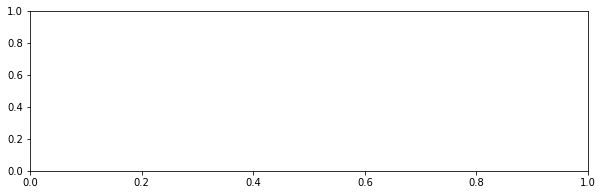

In [18]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(points_x, points_CR[8])
plt.xlabel('Image')
plt.ylabel('Compression Ratio')
plt.subplot(3,1,2)
plt.plot(points_x, points_PSNR[8])
plt.xlabel('Image')
plt.ylabel('PSNR')
plt.subplot(3,1,3)
plt.plot(points_x, points_RMSE[8])
plt.xlabel('Image')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

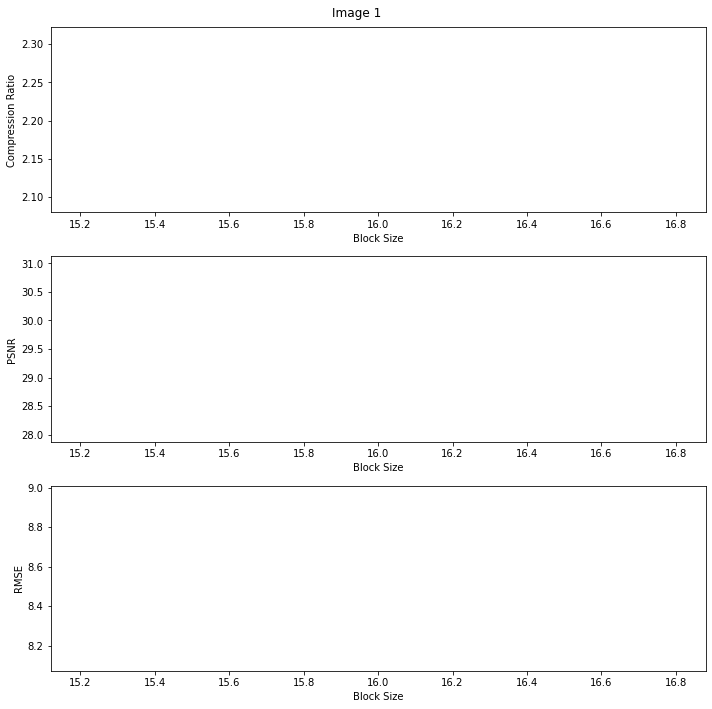

In [19]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
temp = list(points_CR.keys())
plt.plot(temp, [points_CR[i][0] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('Compression Ratio')
plt.subplot(3,1,2)
plt.plot(temp, [points_PSNR[i][0] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('PSNR')
plt.subplot(3,1,3)
plt.plot(temp, [points_RMSE[i][0] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('RMSE')
plt.suptitle('Image 1')
plt.tight_layout()
plt.show()

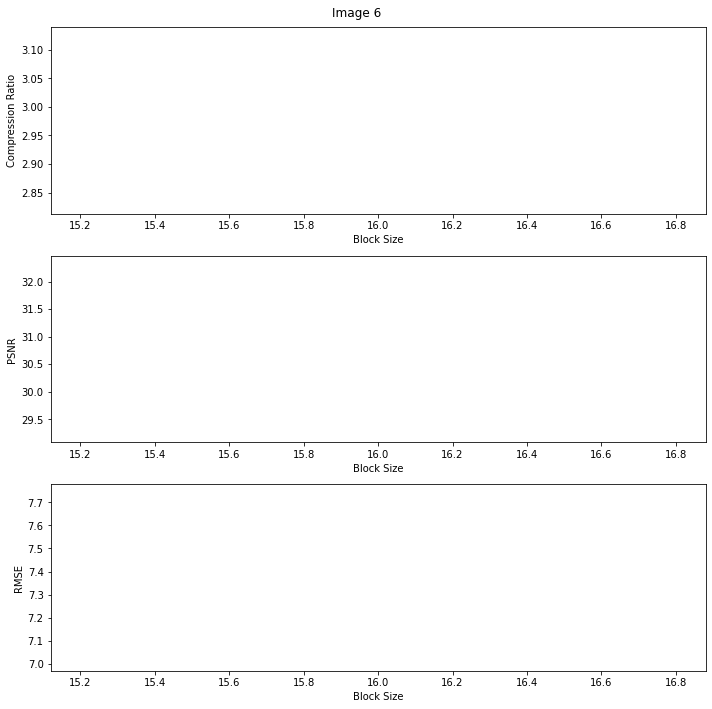

In [20]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
temp = list(points_CR.keys())
plt.plot(temp, [points_CR[i][5] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('Compression Ratio')
plt.subplot(3,1,2)
plt.plot(temp, [points_PSNR[i][5] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('PSNR')
plt.subplot(3,1,3)
plt.plot(temp, [points_RMSE[i][5] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('RMSE')
plt.suptitle('Image 6')
plt.tight_layout()
plt.show()

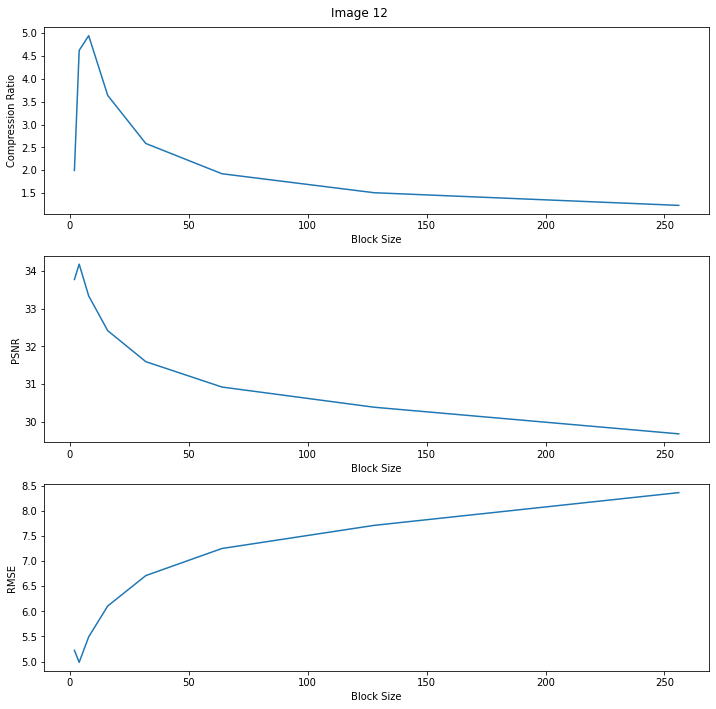

In [47]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
temp = list(points_CR.keys())
plt.plot(temp, [points_CR[i][11] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('Compression Ratio')
plt.subplot(3,1,2)
plt.plot(temp, [points_PSNR[i][11] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('PSNR')
plt.subplot(3,1,3)
plt.plot(temp, [points_RMSE[i][11] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('RMSE')
plt.suptitle('Image 12')
plt.tight_layout()
plt.show()

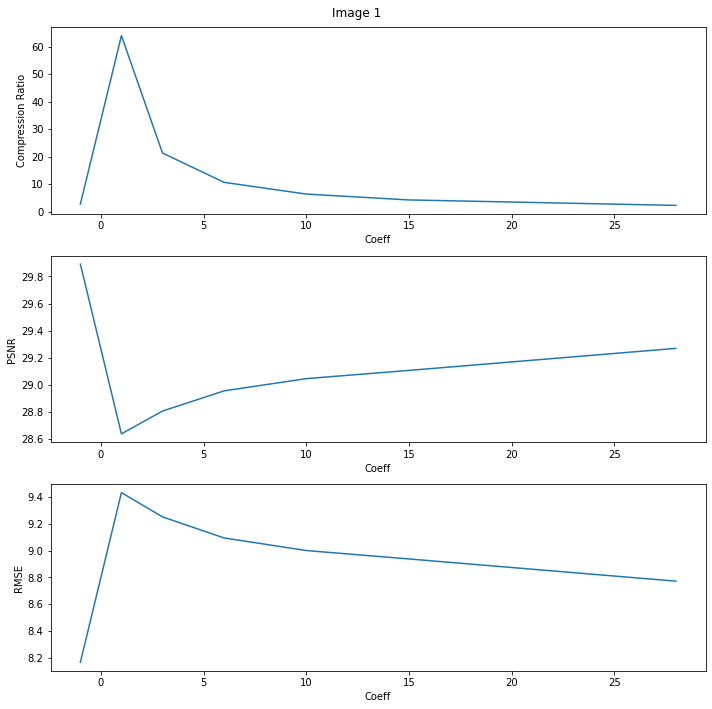

In [44]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
temp = coeff_x
plt.plot(temp, points_coeff_CR[0:7])
plt.xlabel('Coeff')
plt.ylabel('Compression Ratio')
plt.subplot(3,1,2)
plt.plot(temp, points_coeff_PSNR[0:7])
plt.xlabel('Coeff')
plt.ylabel('PSNR')
plt.subplot(3,1,3)
plt.plot(temp, points_coeff_RMSE[0:7])
plt.xlabel('Coeff')
plt.ylabel('RMSE')
plt.suptitle('Image 1')
plt.tight_layout()
plt.show()

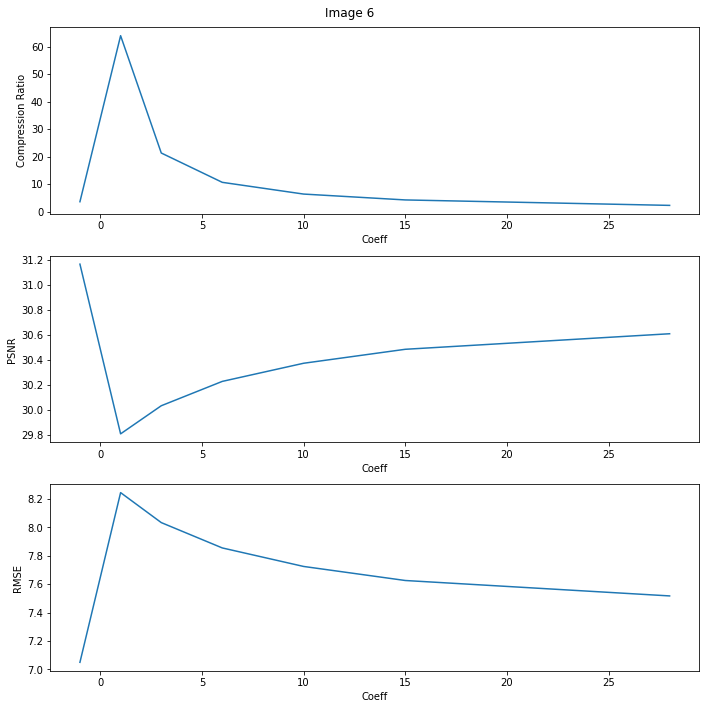

In [45]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
temp = coeff_x
plt.plot(temp, points_coeff_CR[35:42])
plt.xlabel('Coeff')
plt.ylabel('Compression Ratio')
plt.subplot(3,1,2)
plt.plot(temp, points_coeff_PSNR[35:42])
plt.xlabel('Coeff')
plt.ylabel('PSNR')
plt.subplot(3,1,3)
plt.plot(temp, points_coeff_RMSE[35:42])
plt.xlabel('Coeff')
plt.ylabel('RMSE')
plt.suptitle('Image 6')
plt.tight_layout()
plt.show()